Note! The red error below is only used to compute the background of the plots.
The rejected samples on average:  0.7613


/home/dinht/repos/conda_jupyter/bioassaylp.py:32: RuntimeWarning: divide by zero encountered in log
  lp = np.sum(y*np.log(z)+ (n-y)*np.log(1.0-z), axis=-1)
/home/dinht/repos/conda_jupyter/bioassaylp.py:32: RuntimeWarning: invalid value encountered in multiply
  lp = np.sum(y*np.log(z)+ (n-y)*np.log(1.0-z), axis=-1)


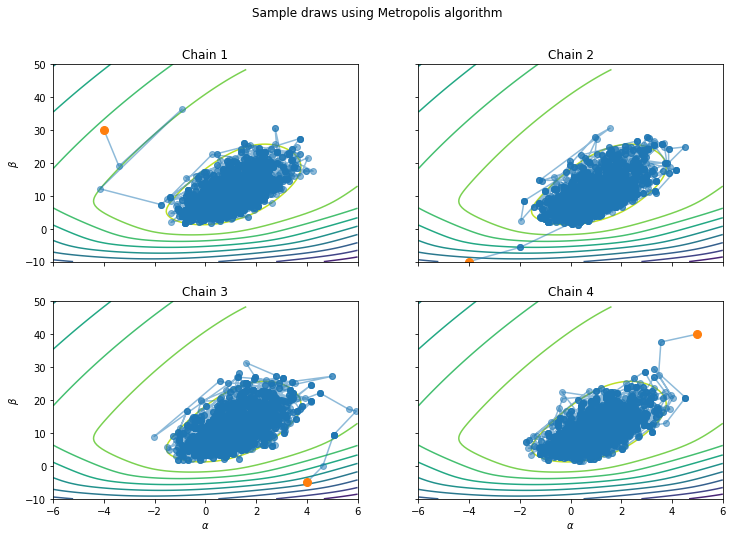

In [3]:
import numpy as np 
import matplotlib.pyplot as plt 
from math import sqrt
from scipy import stats, linalg
from psrf import psrf
from bioassaylp import bioassaylp

np.random.seed(seed=123)

x = np.asarray([-0.86, -0.30, -0.05, 0.73]) 
n = np.asarray([5, 5, 5, 5]) 
y = np.asarray([0, 1, 3, 5])

prior_mean = (0,10)
prior_cov = np.asarray(((2**2, 10), (10, 10**2)))

def get_target_posterior():
    # Construct a grid array of shape (ngrid, ngrid, 2) from X and Y
    def compute_broadcasted(X,Y,ngrid):
        X_broadcasted = np.lib.stride_tricks.as_strided(
            X, shape=(ngrid, ngrid), strides=(0, X.strides[0]))
        Y_broadcasted = np.lib.stride_tricks.as_strided(
            Y, shape=(ngrid, ngrid), strides=(Y.strides[0], 0))
        return {'X':X_broadcasted, 'Y':Y_broadcasted}
    ngrid=100
    broadcasted = compute_broadcasted(np.linspace(-6, 6, ngrid),np.linspace(-10, 50, ngrid),ngrid)
    A_broadcasted=broadcasted['X']
    B_broadcasted=broadcasted['Y']
    
    #Compute target posterior desity
    prior = stats.multivariate_normal.logpdf(x=np.dstack((A_broadcasted, B_broadcasted)), mean=prior_mean, cov=prior_cov)
    likelihood = bioassaylp(A_broadcasted,B_broadcasted,x,y,n)
    posterior = likelihood+prior
    return {'density': posterior, 'A':A_broadcasted, 'B':B_broadcasted}

def log_likelihood(a, b,x,y,n):     
    # these help using chain rule in derivation
    t = a + b * x
    et = np.exp(t)
    z = et / (1. + et)
    z_negative = 1-z
    z_negative = np.array([i if i > 0 else 1e-12 for i in z_negative])
    # negative log posterior (error function to be minimized)
    llh = np.sum(y * np.log(z) + (n - y) * np.log(z_negative), axis=-1)
    return llh

def log_posterior(theta):
    prior = stats.multivariate_normal.logpdf(x=theta, mean=prior_mean, cov=prior_cov)
    likelihood = log_likelihood(theta[0],theta[1],x,y,n)
    return likelihood+prior

rejected_ratio =[]
def metropolis_algorithm(theta0, tmax):
    algo_samples = [theta0]
    accepted=0
    rejected=0
    for t in range(1,tmax):
        # Take next sample from the distribution with the mean of the previous theta, hecne theta at t-1
        theta_prev=algo_samples[t-1]
        theta_next=stats.multivariate_normal.rvs(mean=theta_prev, cov=prior_cov, size=1)   
        
        # Compute posteriors and their ratio r
        p_theta_prev = log_posterior(theta_prev)
        p_theta_next = log_posterior(theta_next)
        r=min(np.exp(p_theta_next-p_theta_prev),1)
        
        #Take probability uniformly
        p=np.random.uniform(0,1,1)

        if (r > p): #Accept new theta
            algo_samples.append(theta_next)
        else: #Keep old theta
            algo_samples.append(theta_prev)
            rejected+=1
            
    #Rejection rule: 60-90%
    rejected_ratio.append(rejected/tmax)
    return np.array(algo_samples)

#Compute metropolis algorithm for 4 chains
nsamples = 5000
theta0 = [[-4,30],[-4,-10],[4,-5],[5,40]]
chains = [ metropolis_algorithm(theta0[i],nsamples) for i in range(0,4) ]
rejected_ratio_avg = np.mean(rejected_ratio)

#Compute target posterior
print("Note! The red error below is only used to compute the background of the plots.")
target_posterior = get_target_posterior()

######################### Sample draws using Metropolis algorithm #########################
def plot_metropolis_simulation():
    print("The rejected samples on average: ", rejected_ratio_avg)
    subplotshape = (2, 2)
    fig, axes = plt.subplots(2, 2, sharex=True, sharey=True,figsize=(12,8), subplot_kw=dict(aspect='auto'))
    fig.suptitle('Sample draws using Metropolis algorithm')
    # set limits
    axes[0,0].set_xlim([-6, 6])
    axes[0,0].set_ylim([-10, 50])

    # set labels
    for i in range(subplotshape[0]):
        axes[i,0].set_ylabel(r'$\beta$')
    for j in range(subplotshape[1]):
        axes[-1,j].set_xlabel(r'$\alpha$')
    chain_axes = [axes[0,0],axes[0,1],axes[1,0],axes[1,1]]
    for i in range(0, len(chains)):
        chain_axes[i].plot(chains[i][:,0],chains[i][:,1], '-o', alpha=0.5)
        chain_axes[i].plot(theta0[i][0],theta0[i][1], 'o', markersize=8)
        chain_axes[i].set_title('Chain '+str(i+1))
        chain_axes[i].contour(target_posterior['A'], target_posterior['B'], target_posterior['density'], 10)
    
plot_metropolis_simulation()
######################### Sample draws without warm-up #########################
#Warm up: remove half of the samples from the beginning
startIndex = int(nsamples/2)

def plot_sample_draws_without_warmup():
    subplotshape = (2, 2)
    fig, axes = plt.subplots(2, 2, sharex=True, sharey=True,figsize=(12,8), subplot_kw=dict(aspect='auto'))
    fig.suptitle('Sample draws after warm-up')
    # set limits
    axes[0,0].set_xlim([-6, 6])
    axes[0,0].set_ylim([-10, 50])

    # set labels
    for i in range(subplotshape[0]):
        axes[i,0].set_ylabel(r'$\beta$')
    for j in range(subplotshape[1]):
        axes[-1,j].set_xlabel(r'$\alpha$')
    chain_axes = [axes[0,0],axes[0,1],axes[1,0],axes[1,1]]
    for i in range(0, len(chains)):
        chain_axes[i].plot(chains[i][startIndex:,0],chains[i][startIndex:,1], 'o', alpha=0.3)
        chain_axes[i].set_title('Chain '+str(i+1))
        chain_axes[i].contour(target_posterior['A'], target_posterior['B'], target_posterior['density'], 10)
    plt.show()
######################### Converge diagnostic #########################
def show_converge_plot():
    fig, axes = plt.subplots(2, 1, sharex=True,figsize=(12,8), subplot_kw=dict(aspect='auto'))
    fig.suptitle('Converge diagnostic')

    # set limits
    axes[0].set_ylim([-6, 6])
    axes[1].set_ylim([-10, 50])
    # set labels
    axes[0].set_ylabel(r'$\alpha$')
    axes[1].set_ylabel(r'$\beta$')
    axes[1].set_xlabel('iteration')

    for i in range(0, len(chains)):
        axes[0].plot(range(0,nsamples),chains[i][:,0], label="Chain "+str(i+1), alpha=0.5)
        axes[1].plot(range(0,nsamples),chains[i][:,1], label="Chain "+str(i+1), alpha=0.5)

    # show Legend
    axes[0].legend()
    axes[1].legend()
    plt.show()

######################### R hat #########################
#R hat compares the means and the variances of the chains
def compute_rhat():
    chains_without_warmup = np.array([c[startIndex:] for c in chains ])
    r_hat = psrf(chains_without_warmup, return_extra=True)
    print(r'R hat value for α and β: ', r_hat[0])
    #print(r'N effective for α and β: ', r_hat[1])
    #print(r'Vh for α and β: ', r_hat[2])
    #print(r'W for α and β: ', r_hat[3])
    #print(r'B for α and β: ', r_hat[4])
    #print(r'Tau for α and β: ', r_hat[5])